In [18]:
from power_calculator import calculate_power
import os
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scrape_cardlists import DATA_PATH
BASE_PWR_PATH = os.path.join(DATA_PATH, "decks", "baseline")
MANUAL_SAVE = os.path.join(DATA_PATH, "decks", "manual_rand")
GPT_SAVE = os.path.join(DATA_PATH, "completed")
DECKS = os.path.join(DATA_PATH, "decks")

In [19]:
def compile_power(directory):
    data = []  # To hold dictionaries from files
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.basename(root)  # Get the current folder name
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                #print(file_path)
                with open(file_path, 'r+', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                    if lines:
                        try:
                            # Convert the last line to a dictionary
                            last_line_dict = ast.literal_eval(lines[-1].strip())
                            # Ensure it's actually a dictionary
                            if isinstance(last_line_dict, dict):
                                last_line_dict['folder'] = folder_name  # Add folder name to the dictionary
                                last_line_dict['commander'] = file
                                if (last_line_dict['cmc'] == 0):
                                    last_line_dict['cmc'] = 3
                                last_line_dict['overall'] = 2 / float(last_line_dict['cmc']) + ( int(last_line_dict['draw'])/2 + int(last_line_dict['ramp'])/2) / 2 + int(last_line_dict['interaction'])/20
                                data.append(last_line_dict)
                                lines[-1] = str(last_line_dict)
                                f.seek(0)
                                f.writelines(lines)
                        except (ValueError, SyntaxError):
                            print(f"Error processing file: {file_path}")
                            continue
    return pd.DataFrame(data)

df = compile_power(DECKS)
for col in df:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

df.head()

,overall,cmc,ramp,draw,interaction,folder,commander
0,17.471311,2.772727,32,35,0,baseline,AesiTyrantofGyreStrait.txt
1,1.284071,3.424242,1,0,9,baseline,AgrusKosEternalSoldier.txt
2,1.305837,3.953846,1,2,1,baseline,AkromaVisionofIxidor.txt
3,7.880612,3.769231,2,26,7,baseline,AlandraSkyDreamer.txt
4,8.996218,3.661538,4,29,4,baseline,AotheDawnSky.txt


In [20]:
df.to_pickle("../data/power.pkl")

In [21]:
df.groupby('folder').count()

,overall,cmc,ramp,draw,interaction,commander
folder,,,,,,
baseline,189,189,189,189,189,189
edhrec,189,189,189,189,189,189
gpt,189,189,189,189,189,189
manual_rand,189,189,189,189,189,189


In [22]:
df[df.columns.difference(['commander'])].groupby('folder').mean()

,cmc,draw,interaction,overall,ramp
folder,,,,,
baseline,3.452893,10.222222,7.222222,4.506141,3.994709
edhrec,2.620288,11.910053,8.322751,7.247856,12.243386
gpt,3.342160,11.804233,10.005291,5.819461,7.058201
manual_rand,3.354173,10.968254,8.031746,4.904552,4.640212


In [23]:
df

,overall,cmc,ramp,draw,interaction,folder,commander
0,17.471311,2.772727,32,35,0,baseline,AesiTyrantofGyreStrait.txt
1,1.284071,3.424242,1,0,9,baseline,AgrusKosEternalSoldier.txt
2,1.305837,3.953846,1,2,1,baseline,AkromaVisionofIxidor.txt
3,7.880612,3.769231,2,26,7,baseline,AlandraSkyDreamer.txt
4,8.996218,3.661538,4,29,4,baseline,AotheDawnSky.txt
...,...,...,...,...,...,...,...
751,2.806522,3.593750,0,7,10,manual_rand,XunYuWeiAdvisor.txt
752,4.513877,3.546875,3,11,9,manual_rand,YaroktheDesecrated.txt
753,0.666667,3.000000,0,0,0,manual_rand,YoshimaruEverFaithful.txt
754,2.356635,3.296875,1,4,10,manual_rand,ZhangHeWeiGeneral.txt


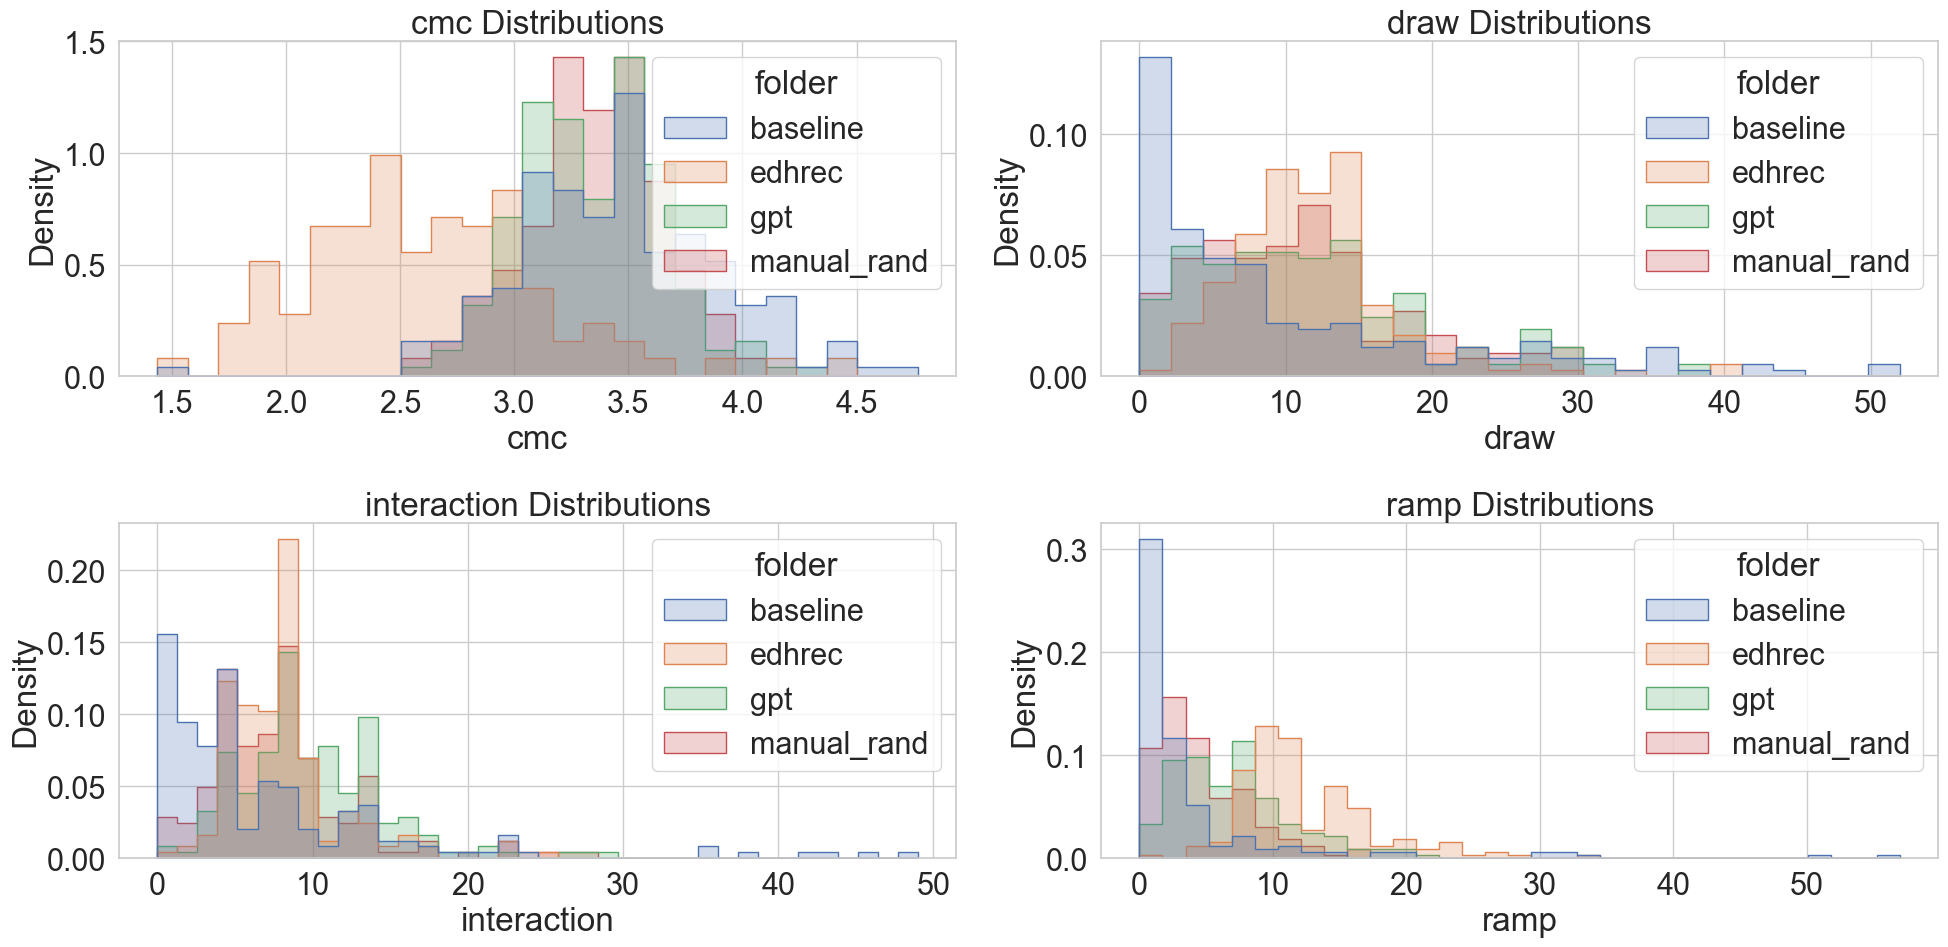

In [24]:
sns.set(style="whitegrid", font_scale=2)
plt.figure(figsize=(20, 10))

# Create a column list excluding 'folder'
columns = df.columns.difference(['folder', 'overall', 'commander'])

# Plotting
for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=column, hue="folder", element="step", stat="density", common_norm=False)
    plt.title(f'{column} Distributions')

plt.tight_layout()
plt.savefig("../docs/distributions.png")
plt.show()

In [25]:
df[df['cmc'] == 0]

,overall,cmc,ramp,draw,interaction,folder,commander


In [26]:
from scipy.stats import f_oneway

for col in df.columns.difference(['folder', 'commander']):
    # Similar setup as Kruskal-Wallis but for ANOVA
    data = [df[df['folder'] == folder][col] for folder in df['folder'].unique()]

    # Perform ANOVA
    stat, p = f_oneway(*data)

    print(col + ' Statistics= %.3f, p= %.3f' % (stat, p))
    if p > 0.05:
        print('Same means across all groups (fail to reject H0)')
    else:
        print('Different means across some groups (reject H0)')

cmc Statistics= 168.703, p= 0.000
Different means across some groups (reject H0)
draw Statistics= 1.732, p= 0.159
Same means across all groups (fail to reject H0)
interaction Statistics= 7.679, p= 0.000
Different means across some groups (reject H0)
overall Statistics= 36.569, p= 0.000
Different means across some groups (reject H0)
ramp Statistics= 88.757, p= 0.000
Different means across some groups (reject H0)


In [27]:
df.columns.difference(['baseline'])

Index(['cmc', 'commander', 'draw', 'folder', 'interaction', 'overall', 'ramp'], dtype='object')

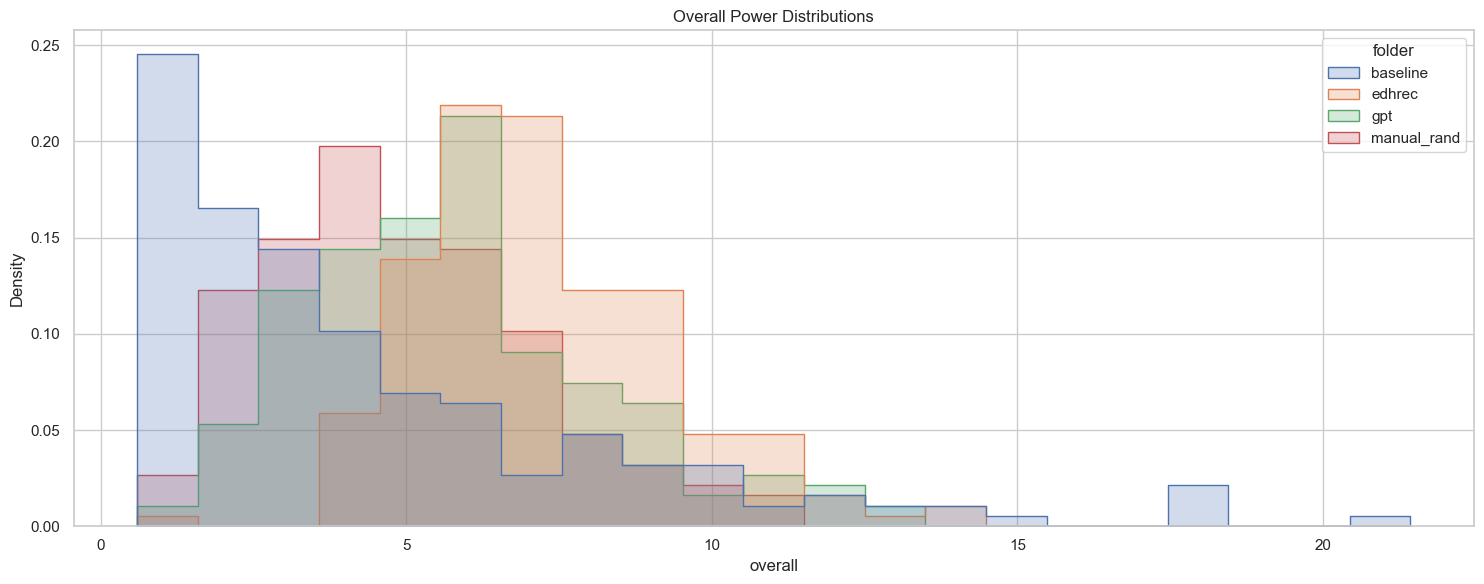

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'overall' is the column of interest
sns.set(style="whitegrid")

# Calculate appropriate bin edges to cover the full range of data without gaps
bin_edges = range(int(df['overall'].min()), int(df['overall'].max()) + 2)  # +2 to ensure the last data point is included

plt.figure(figsize=(15, 6))  # Adjust size as needed
sns.histplot(data=df, x='overall', hue='folder', binwidth=1, bins=bin_edges, stat="density", element="step", common_norm=False)
plt.title('Overall Power Distributions')
plt.tight_layout()
plt.savefig("../docs/power_distributions.png")
plt.show()